In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log, square, sqrt, power, arange, ones, zeros, isscalar,\
    array, outer, pi, sin, cos, expand_dims, repeat, full, concatenate, ravel
from numpy.random import normal
from scipy.optimize import least_squares, minimize
%matplotlib inline

In [98]:
# Trade data

stock_name = 'MSFT.O'

df = pd.read_csv('NSQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
apple = df[df['RIC'] == stock_name]
apple['Date'] = pd.to_datetime(apple['Local_Date_Time']).dt.date

qqq = pd.read_csv('QQQ_OneYear100test_Sept21.csv', 
                   usecols=['Local_Date_Time','RIC','Open','High','Low','Close','VWAP','NumberOfTrades','Volume'],
                   dtype={'Local_Date_Time': str,
                          'RIC': str, 
                          'Open': np.float64,
                          'High': np.float64,
                          'Low': np.float64,
                          'Close': np.float64,
                          'VWAP': np.float64,
                          'NumberOfTrades': int,
                          'Volume': int},
                   skipinitialspace=True,
                   parse_dates=True)
qqq['Date'] = pd.to_datetime(qqq['Local_Date_Time']).dt.date

<ipython-input-98-4c45ab35bfa1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple['Date'] = pd.to_datetime(apple['Local_Date_Time']).dt.date


In [99]:
# Auction price data
auction = pd.read_csv('NSQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
apple_auction = auction[auction['RIC'] == stock_name]
apple_auction['Date'] = pd.to_datetime(apple_auction['Local_Date_Time']).dt.date

auction_qqq = pd.read_csv('QQQ_OneYear100closeA_Sept21.csv',
                      skipinitialspace=True,
                      parse_dates=True)
auction_qqq['Date'] = pd.to_datetime(auction_qqq['Local_Date_Time']).dt.date

<ipython-input-99-c687e5b9a9f5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_auction['Date'] = pd.to_datetime(apple_auction['Local_Date_Time']).dt.date


In [100]:
# Data Processing (10 minute intervals)

dates = apple['Date'].unique()
daily_volatility = []
daily_volatility_minus4pm = []
daily_return = []
avg_20day_volatility = []
stocks = []
dates_final = []
auction_log_returns = []
auction_log_returns_340350 = []
volumes = []

for date in dates:
    
    apple_today = apple[apple['Date'] == date]
    apple_auction_today = apple_auction[apple_auction['Date'] == date]
    
    apple_today = apple_today.set_index(pd.DatetimeIndex(apple_today['Local_Date_Time']))
    apple_today_10min_max = pd.DataFrame(apple_today['High'].resample("10T").max())
    apple_today_10min_min = pd.DataFrame(apple_today['Low'].resample("10T").min())
    apple_today_10min_open = pd.DataFrame(apple_today['Open'].resample("10T").first())
    apple_today_10min_close = pd.DataFrame(apple_today['Close'].resample("10T").last())
    apple_today_10min_volume = pd.DataFrame(apple_today['Volume'].resample("10T").sum())
    apple_today_10min = apple_today_10min_max.join(apple_today_10min_min)
    apple_today_10min = apple_today_10min.join(apple_today_10min_open)
    apple_today_10min = apple_today_10min.join(apple_today_10min_close)
    apple_today_10min = apple_today_10min.join(apple_today_10min_volume)
#     apple_today_10min['log_returns'] = abs(np.log(apple_today_10min['Close']/apple_today_10min['Open'])) # alternate volatility formula
    apple_today_10min['log_returns'] = np.sqrt(0.5*np.square(np.log(apple_today_10min['High']/apple_today_10min['Low'])) - (2*np.log(2)-1) * np.square(np.log(apple_today_10min['Close']/apple_today_10min['Open'])))
    volatility_today = apple_today_10min['log_returns'].values
    return_today = (apple_today_10min['Close']/apple_today_10min['Open']).values
    
    if len(volatility_today) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
        
    # Dates for which the trade data is complete
    dates_final.append(date)
    
    auction_log_returns_today = abs(np.log(apple_auction_today['Price'].iloc[0]/apple_today_10min['Open'][-1]))
    auction_log_returns.append(auction_log_returns_today)
    
    auction_log_returns_today_340350 = abs(np.log(apple_today_10min['Open'][-1]/apple_today_10min['Open'][-2]))
    auction_log_returns_340350.append(auction_log_returns_today_340350)
    
    # 10 minute interval volatility * number of complete trade days
    stocks.append(volatility_today)
    
    # Average daily volatility (later used for 20 day moving average)
    daily_volatility.append(np.sqrt(39)*np.sqrt(np.mean(np.square(apple_today_10min['log_returns'].values))))
    daily_volatility_minus4pm.append(np.sqrt(38)*np.sqrt(np.mean(np.square(apple_today_10min['log_returns'].values[:-1]))))
    daily_return.append(return_today)
    
    # Total volume for each complete trade day between 930 and 1550
    volumes.append(sum(apple_today_10min[:-1]['Volume']))

daily_return = np.array(daily_return)
volatility_df = pd.DataFrame({'Date':dates_final, 'daily_volatility': daily_volatility, 'daily_volatility_minus4pm': daily_volatility_minus4pm})
volatility_df['diff'] = volatility_df['daily_volatility']-volatility_df['daily_volatility_minus4pm']
volatility_df['volatility_ewma20'] = np.array([None] + [i for i in volatility_df['daily_volatility'].ewm(span=20).mean()][:-1])

stocks = stocks[20:]
stocks = np.vstack(stocks).T # Training data for Anderson model
avg_20day_volatility_raw = np.array(volatility_df['volatility_ewma20'])
avg_20day_volatility = np.array(volatility_df['volatility_ewma20'][20:]) # Sigma_t input for Anderson model

In [109]:
# Data Processing (10 minute intervals)

dates_qqq = qqq['Date'].unique()
daily_volatility_qqq = []
daily_volatility_qqq_minus4pm = []
daily_return_qqq = []
avg_20day_volatility_qqq = []
stocks_qqq = []
dates_final_qqq = []
auction_log_returns_qqq = []
volumes_qqq = []

# i = 0
for date in dates_qqq:
    
    qqq_today = qqq[qqq['Date'] == date]
    qqq_auction_today = auction_qqq[auction_qqq['Date'] == date]
    
    qqq_today = qqq_today.set_index(pd.DatetimeIndex(qqq_today['Local_Date_Time']))
    qqq_today_10min_max = pd.DataFrame(qqq_today['High'].resample("10T").max())
    qqq_today_10min_min = pd.DataFrame(qqq_today['Low'].resample("10T").min())
    qqq_today_10min_open = pd.DataFrame(qqq_today['Open'].resample("10T").first())
    qqq_today_10min_close = pd.DataFrame(qqq_today['Close'].resample("10T").last())
    qqq_today_10min_volume = pd.DataFrame(qqq_today['Volume'].resample("10T").sum())
    qqq_today_10min = qqq_today_10min_max.join(qqq_today_10min_min)
    qqq_today_10min = qqq_today_10min.join(qqq_today_10min_open)
    qqq_today_10min = qqq_today_10min.join(qqq_today_10min_close)
    qqq_today_10min = qqq_today_10min.join(qqq_today_10min_volume)
#     qqq_today_10min['log_returns'] = abs(np.log(qqq_today_10min['Close']/qqq_today_10min['Open'])) # alternate volatility formula
    qqq_today_10min['log_returns'] = np.sqrt(0.5*np.square(np.log(qqq_today_10min['High']/qqq_today_10min['Low']))-(2*np.log(2)-1)*np.square(np.log(qqq_today_10min['Close']/qqq_today_10min['Open'])))
    volatility_today_qqq = qqq_today_10min['log_returns'].values
    return_today_qqq = (qqq_today_10min['Close']/qqq_today_10min['Open']).values
    
    if len(volatility_today_qqq) != 39: # Skip if there are fewer than 390 minutes of trading data
        continue
        
    # Dates for which the trade data is complete
    dates_final_qqq.append(date)
    
    auction_log_returns_today_qqq = abs(np.log(qqq_auction_today['Price'].iloc[0]/qqq_today_10min['Open'][-1]))
    auction_log_returns_qqq.append(auction_log_returns_today_qqq)
    
    # 10 minute interval volatility * number of complete trade days
    stocks_qqq.append(volatility_today_qqq)
    
    # Average daily volatility (later used for 20 day moving average)
    daily_volatility_qqq.append(np.sqrt(39)*np.sqrt(np.mean(np.square(qqq_today_10min['log_returns'].values))))
    daily_volatility_qqq_minus4pm.append(np.sqrt(38)*np.sqrt(np.mean(np.square(qqq_today_10min['log_returns'].values[:-1]))))
    daily_return_qqq.append(return_today_qqq)
    
    # Total volume for each complete trade day between 930 and 1550
    volumes_qqq.append(sum(qqq_today_10min[:-1]['Volume']))

daily_return_qqq = np.array(daily_return_qqq)
volatility_df_qqq = pd.DataFrame({'Date':dates_final_qqq, 'daily_volatility': daily_volatility_qqq, 'daily_volatility_qqq_minus4pm': daily_volatility_qqq_minus4pm})
volatility_df_qqq['volatility_ewma20'] = np.array([None] + [i for i in volatility_df_qqq['daily_volatility'].ewm(span=20).mean()][:-1])

stocks_qqq = stocks_qqq[20:]
stocks_qqq = np.vstack(stocks_qqq).T # Training data for Anderson model
avg_20day_volatility_raw_qqq = np.array(volatility_df_qqq['volatility_ewma20'])
avg_20day_volatility_qqq = np.array(volatility_df_qqq['volatility_ewma20'][20:]) # Sigma_t input for Anderson model

In [111]:
# Calculating beta for the stock
daily_beta = []

for i in range(251):
    today_corr = np.corrcoef(daily_return[i][:-1], daily_return_qqq[i][:-1])[1][0]
    today_beta = today_corr * np.sqrt(np.var(daily_return[i])) / np.sqrt(np.var(daily_return_qqq[i]))
    daily_beta.append(today_beta)


In [25]:
class FlexibleFourierRegression():
    '''
    See P.152 Anderson(1997) Appendix B for details
    '''
    
    def __init__(self, N, J=0, P=0, di=[]):
        self.J = J
        self.D = len(di)
        self.P = P
        
        self.N = N
        self.di = di
        self.Id = zeros(shape=(N,))
        self.mu0 = ones(shape=(J+1,))
        self.mu1 = ones(shape=(J+1,))
        self.mu2 = ones(shape=(J+1,))
        self.lamb = ones(shape=(self.D,))
        self.gamma = ones(shape=(P, J+1))
        self.delta = ones(shape=(P, J+1))
        self.p = arange(1, P + 1, 1)
        self.x = concatenate([self.mu0.ravel(), self.mu1.ravel(), self.mu2.ravel(),
            self.lamb.ravel(), self.gamma.ravel(), self.delta.ravel()])    
        
    def train(self, y, sigma_t, tol=0.1):
        """
        Trains model using flexible fourier functional form.
        
        Parameters
        ----------
        y : dependent variable
        
        sigma_t: estimated conditional volatility for day t,
        sigma_t is scalar or vector depending on vector=False/True.
        
        
        
        Returns
        -------
        Regression stats
        """
        assert y.shape[0] == self.N, "input y should have shape[0] == N:"
        n = arange(0, self.N, 1)
        J = self.J
        ## Learning weights for the following parameters
        ## self.mu0, self.mu1, self.mu2, self.lamb, self.gamma, self.delta

        def lsq_fun(x):
            
            mu0 = x[0: J+1]
            mu1 = x[J+1: 2*J+2]
            mu2 = x[2*J+2: 3*J+3]
            lamb = x[3*J+3:3*J+3+self.D]
            gamma = x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
            delta = x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))
            
            gamma = repeat(expand_dims(gamma, axis=0), self.N, axis=0)
            delta = repeat(expand_dims(delta, axis=0), self.N, axis=0)            
            N1 = (self.N + 1) / 2
            N2 = (self.N + 1) * (self.N + 2) / 6            
            
            dummy = self.Id.copy()
            dummy[self.di] = lamb
            dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
            
            mu0 = repeat(expand_dims(mu0, axis=0), self.N, axis=0)
            quad = mu0 + outer(n / N1, mu1) + outer(square(n) / N2, mu2)
            cosine = cos(2 * outer(n, self.p) * pi / self.N)
            sine = sin(2 * outer(n, self.p) * pi / self.N)
            cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
            sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)  
            fourier_expand = gamma * cosine + delta * sine
            fourier = fourier_expand.sum(axis=1)

            sigma = full(fill_value=sigma_t, shape=(self.N, J+1))
            for j in range(J+1):
                sigma[:,j] = power(sigma[:,j], j)   

            result = (sigma * (quad + dummy + fourier)).sum(axis=-1)
            cost = square(result - y).mean()
            
            return cost

        def lsq_fun_vec(x):
            
            mu0 = x[0: J+1]
            mu1 = x[J+1: 2*J+2]
            mu2 = x[2*J+2: 3*J+3]
            lamb = x[3*J+3:3*J+3+self.D]
            gamma = x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
            delta = x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))
            
            gamma = repeat(expand_dims(gamma, axis=0), self.N, axis=0)
            delta = repeat(expand_dims(delta, axis=0), self.N, axis=0)            
            N1 = (self.N + 1) / 2
            N2 = (self.N + 1) * (self.N + 2) / 6            
            
            dummy = self.Id.copy()
            dummy[self.di] = lamb
            dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
            
            mu0 = repeat(expand_dims(mu0, axis=0), self.N, axis=0)
            quad = mu0 + outer(n / N1, mu1) + outer(square(n) / N2, mu2)
            cosine = cos(2 * outer(n, self.p) * pi / self.N)
            sine = sin(2 * outer(n, self.p) * pi / self.N)
            cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
            sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)  
            fourier_expand = gamma * cosine + delta * sine
            fourier = fourier_expand.sum(axis=1)
            
            component = fourier + quad + dummy
            component = repeat(expand_dims(component, axis=1), len(sigma_t), axis=1)  
            
            sigma = repeat(expand_dims(sigma_t, axis=0), self.N, axis=0)
            sigma_J = repeat(expand_dims(sigma, axis=-1), J+1, axis=-1)
            for j in range(J+1):
                sigma_J[:,:,j] = power(sigma_J[:,:,j], j)   
            
            result = (sigma_J * component).sum(axis=-1)
            cost = square(result - y).mean()
            
            return cost
        

        sigma_t = ravel(sigma_t)
        assert sigma_t.shape[0] == y.shape[1], "sigma_t should have shape (t, ) and y should have shape (N, t)"
        res = minimize(lsq_fun_vec, self.x, tol=tol)

        self.mu0 = res.x[0: J+1]
        self.mu1 = res.x[J+1: 2*J+2]
        self.mu2 = res.x[2*J+2: 3*J+3]
        self.lamb = res.x[3*J+3:3*J+3+self.D]
        self.gamma = res.x[3*J+3+self.D: 3*J+3+self.D+self.P*(J+1)].reshape((self.P, J+1))
        self.delta = res.x[3*J+3+self.D+self.P*(J+1): 3*J+3+self.D+2*self.P*(J+1)].reshape((self.P, J+1))            
        
        return res
        
    def predict(self, sigma_t, vector=False):
        
        N = self.N
        D = self.D
        J = self.J
        P = self.P
        p = self.p
        
        gamma = repeat(expand_dims(self.gamma, axis=0), N, axis=0)
        delta = repeat(expand_dims(self.delta, axis=0), N, axis=0)
        n = arange(0, N, 1)
        N1 = (N + 1) / 2
        N2 = (N + 1) * (N + 2) / 6
        
        dummy = self.Id.copy()
        dummy[self.di] = self.lamb
        dummy = repeat(expand_dims(dummy, axis=1), J+1, axis=1)
        
        quad = self.mu0 + outer(n / N1, self.mu1) + outer(square(n) / N2, self.mu2)
        
        cosine = cos(2 * outer(n, self.p) * pi / N)
        sine = sin(2 * outer(n, self.p) * pi / N)
        cosine = repeat(expand_dims(cosine, axis=-1), J+1, axis=-1)
        sine = repeat(expand_dims(sine, axis=-1), J+1, axis=-1)
        fourier_expand = gamma * cosine + delta * sine
        fourier = fourier_expand.sum(axis=1)

        sigma_t = ravel(sigma_t)
        component = fourier + quad + dummy
        component = repeat(expand_dims(component, axis=1), sigma_t.shape[0], axis=1)  
        sigma = repeat(expand_dims(sigma_t, axis=0), self.N, axis=0)
        sigma_J = repeat(expand_dims(sigma, axis=-1), J+1, axis=-1)
        for j in range(J+1):
            sigma_J[:,:,j] = power(sigma_J[:,:,j], j)               
        result = (sigma_J * component).sum(axis=-1)
            
        return result

In [26]:
stocks2 = stocks.T
stocks2 = stocks2[:200].T
avg_20day_volatility2 = avg_20day_volatility[:200]

In [9]:
fourier = FlexibleFourierRegression(N=39, di=[], J=6, P=30) # 39 10-minute intervals in each trade day
res = fourier.train(stocks, avg_20day_volatility, 0.0000005)
print("optimizer success: {}".format(res.success))
print("objective function (mse): {:.8f}".format(res.fun))

optimizer success: True
objective function (mse): 0.00000062


In [10]:
### Hyper-parameter tuning
# for J in [4,6,8,10,12]:
#     for P in [15,20,25,30,35]:
#         fourier = FlexibleFourierRegression(N=39, di=[], J=J, P=P) # 39 10-minute intervals in each trade day
#         res = fourier.train(stocks, avg_20day_volatility, 0.0000005)
# #         print("optimizer success: {}".format(res.success))
# #         print("objective function (mse): {:.5f}".format(res.fun))

#         results = []
#         for n in range(200,231):
#             result = fourier.predict(avg_20day_volatility[n])
#             results.append(result[-1][0])
        
#         print(J,P)
#         print(r2_score([i[0] for i in np.array(final_df[['Auction_Log_Returns']][200:])], results))
#         print()

NameError: name 'final_df' is not defined

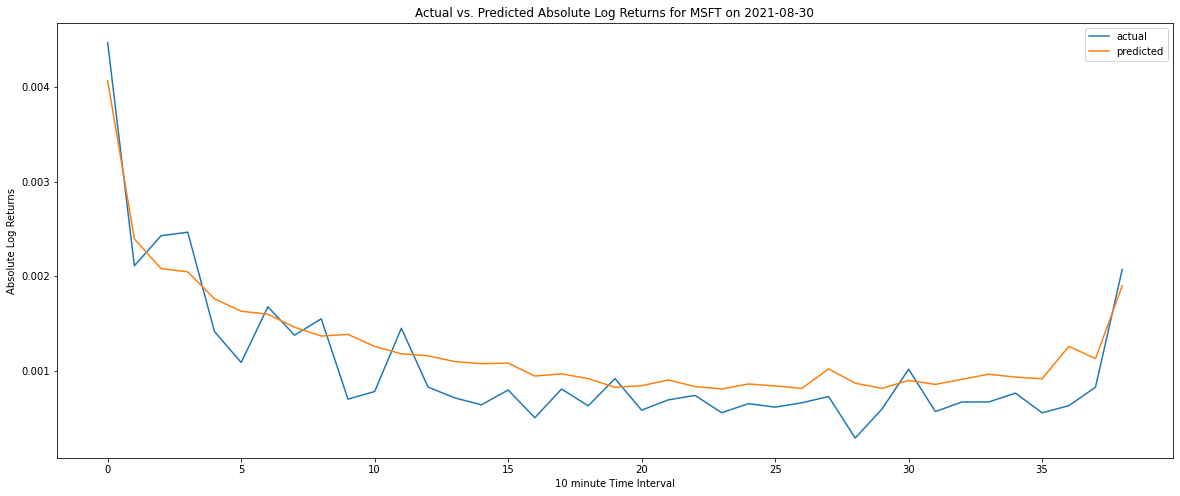

In [112]:
n=230
result = fourier.predict(avg_20day_volatility[n])

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(stocks.T[n], label="actual")
ax.plot(result, label="predicted")
plt.xlabel("10 minute Time Interval")
plt.ylabel("Absolute Log Returns")
plt.title('Actual vs. Predicted Absolute Log Returns for MSFT on 2021-08-30')
ax.legend()

In [113]:
# QQQ
stocks2_qqq = stocks_qqq.T
stocks2_qqq = stocks2_qqq[:200].T
avg_20day_volatility2_qqq = avg_20day_volatility_qqq[:200]

In [114]:
fourier_qqq = FlexibleFourierRegression(N=39, di=[], J=6, P=30) # 39 10-minute intervals in each trade day
res_qqq = fourier_qqq.train(stocks_qqq, avg_20day_volatility_qqq, 0.0000005)
print("optimizer success: {}".format(res_qqq.success))
print("objective function (mse): {:.8f}".format(res_qqq.fun))

optimizer success: True
objective function (mse): 0.00000047


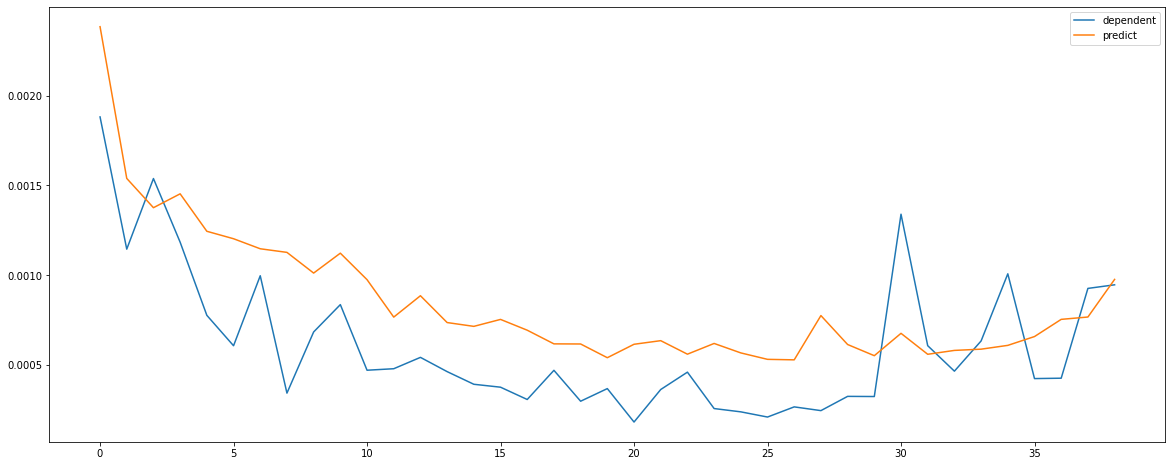

In [116]:
n=230
result_qqq = fourier_qqq.predict(avg_20day_volatility_qqq[n])

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(stocks_qqq.T[n], label="dependent")
ax.plot(result_qqq, label="predict")
ax.legend()

In [117]:
results = [None for i in range(20)]
results_full = []

for vol in avg_20day_volatility:
    result = fourier.predict(vol)
    results_full.append(np.array([res[0] for res in result]))
    results.append(result[-1][0])
results = np.array(results)
results_full = np.array(results_full)

In [118]:
results_qqq = [None for i in range(20)]
for vol in avg_20day_volatility_qqq:
    result_qqq = fourier_qqq.predict(vol)
    results_qqq.append(result_qqq[-1][0])
results_qqq = np.array(results_qqq)

In [119]:
# Simple linear regression with Anderson coefficient
final_df = pd.DataFrame({
    'Date': dates_final, 
    'Volume': volumes,
    'Volume_qqq': volumes_qqq,
    
    'Daily_Volatility_minus4pm': volatility_df['daily_volatility_minus4pm'],
    'Daily_Volatility': volatility_df['daily_volatility'],
    'Auction_Volatility_prop': volatility_df['daily_volatility']/volatility_df['daily_volatility_minus4pm'],
    
    'Daily_Volatility_qqq_minus4pm': volatility_df_qqq['daily_volatility_qqq_minus4pm'],
    
    'Avg20_Volatility': avg_20day_volatility_raw, 
    'Avg20_Volatility_qqq': avg_20day_volatility_raw_qqq, 
    'Beta': daily_beta,
    'Anderson': results,
    'Anderson_qqq': results_qqq,
    'Auction_Log_Returns': auction_log_returns
})

# daily_volatility_minus4pm.append(np.sqrt(39)*np.sqrt(np.mean(np.square(apple_today_10min['log_returns'].values[:-1]))))

# for i in range(1, len(final_df)):
    
#     # Predict today's "Daily_Volatility" based on yesterday's ratio and today's volatility before 4pm
#     today_step1 = final_df.loc[i, 'Daily_Volatility_minus4pm']*final_df.loc[i-1, 'Auction_Volatility_prop']
#     today_step2 = (today_step1/np.sqrt(39))**2
#     int_step = (final_df.loc[i, 'Daily_Volatility_minus4pm']/np.sqrt(38))**2
#     today_step3 = np.sqrt(max(0, today_step2*39-int_step*38))
#     final_df.loc[i, 'Auction_Volatility_pred'] = today_step3

# stocks = stocks.T
# for i in range(len(final_df)-20):
    
#     # Get today's ratio
#     ratio = sum(stocks[i][:-1])/sum(results_full[i][:-1])
#     vol_pred = results_full[i][-1] * ratio
#     final_df.loc[i+20, 'Auction_Volatility_pred2'] = vol_pred
    
final_df = final_df[final_df['Anderson'] > -float('inf')]
final_df

,Date,Volume,Volume_qqq,Daily_Volatility_minus4pm,Daily_Volatility,Auction_Volatility_prop,Daily_Volatility_qqq_minus4pm,Avg20_Volatility,Avg20_Volatility_qqq,Beta,Anderson,Anderson_qqq,Auction_Log_Returns
20,2020-09-30,19083581,34670209,0.015338,0.015865,1.034380,0.012674,0.0182034,0.0150915,1.076132,0.00367114,0.00267682,0.001615
21,2020-10-01,15528087,29708330,0.013371,0.013546,1.013058,0.011105,0.0179497,0.0148939,0.923397,0.00363372,0.00264728,0.000706
22,2020-10-02,20624465,47305127,0.015882,0.016182,1.018895,0.015322,0.0174781,0.0144991,0.997670,0.00356297,0.00258742,0.005079
23,2020-10-05,12430068,18568359,0.008086,0.008218,1.016369,0.006575,0.0173409,0.0146116,0.909705,0.0035421,0.0026046,0.001475
24,2020-10-06,18380375,33228184,0.017072,0.017611,1.031619,0.015872,0.0163856,0.0137801,0.882609,0.00339318,0.00247568,0.001799
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2021-08-26,10177095,21595483,0.007056,0.007216,1.022757,0.006207,0.00880319,0.00585322,0.919565,0.00198999,0.00101042,0.001904
247,2021-08-27,11442471,18933101,0.008055,0.008204,1.018419,0.005883,0.00865206,0.00589517,1.367197,0.00195807,0.00101929,0.000434
248,2021-08-30,9032609,18151158,0.006824,0.006934,1.016158,0.004029,0.00860936,0.00590158,1.440268,0.00194902,0.00102065,0.000066
249,2021-08-31,8654638,18406465,0.006888,0.007519,1.091602,0.005277,0.00844978,0.00572902,1.208496,0.0019151,0.000984093,0.004858


In [121]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

results = []
for n in range(200,231):
    result = fourier.predict(avg_20day_volatility[n])
    results.append(result[-1][0])

print(r2_score([i[0] for i in np.array(final_df[['Auction_Log_Returns']][200:])], results))

-0.4108126196151991


In [122]:
####################################
# Linear Model with Anderson
####################################

from sklearn.linear_model import LinearRegression
model_volatility = LinearRegression()
model_volatility.fit(final_df[['Volume','Avg20_Volatility','Anderson']][:200], final_df[['Auction_Log_Returns']][:200])

LinearRegression()

In [123]:
####################################
# Confidence Interval with Anderson
####################################

y_pred = model_volatility.predict(final_df[['Volume','Avg20_Volatility','Anderson']][200:])
y_pred_var = pd.DataFrame({'Date': final_df['Date'][200:], 'pred_ratio': [np.exp(i[0]) for i in y_pred]})

# Rows with 3:50pm information
apple_price_1550 = apple[apple['Local_Date_Time'].str.contains("15:50")]

# Merge the above two tables
merged1 = apple_price_1550.merge(apple_auction, on='Date')
merged2 = merged1.merge(y_pred_var, on='Date')
merged2['Predicted_Variance'] = merged2['Open']*merged2['pred_ratio'] - merged2['Open']
merged2.loc[(merged2['Price']<merged2['Open']+merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+2*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+2*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+3*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+3*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = False

print('Within 1 confidence interval was', merged2[merged2['Within_1Interval'] == True].shape[0] / merged2.shape[0])
print('Within 2 confidence intervals was', merged2[merged2['Within_2Interval'] == True].shape[0] / merged2.shape[0])
print('Within 3 confidence intervals was', merged2[merged2['Within_3Interval'] == True].shape[0] / merged2.shape[0])

Within 1 confidence interval was 0.6774193548387096
Within 2 confidence intervals was 0.9032258064516129
Within 3 confidence intervals was 0.967741935483871


With the Anderson model, it follows the normal distribution closely.

In [124]:
np.mean(merged2['Predicted_Variance']) # narrower than not using Anderson

0.4421429189839431

In [125]:
####################################
# Linear Model with Anderson QQQ
####################################

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

# interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
# X_inter = interaction.fit_transform(final_df[['Volume','Avg20_Volatility','Avg20_Volatility_qqq','Beta','Anderson']][:200])

model_volatility_qqq = LinearRegression()
model_volatility_qqq.fit(final_df[['Volume','Avg20_Volatility','Avg20_Volatility_qqq','Beta','Anderson']][:200], final_df[['Auction_Log_Returns']][:200])

# model_volatility_qqq = Ridge()
# model_volatility_qqq.fit(final_df[['Volume','Avg20_Volatility','Avg20_Volatility_qqq','Anderson']][:200], final_df[['Auction_Log_Returns']][:200])


LinearRegression()

In [126]:
####################################
# Confidence Interval with QQQ
####################################

y_pred_qqq = model_volatility_qqq.predict(final_df[['Volume','Avg20_Volatility','Avg20_Volatility_qqq','Beta','Anderson']][200:])
y_pred_var_qqq = pd.DataFrame({'Date': final_df['Date'][200:], 'pred_ratio': [np.exp(i[0]) for i in y_pred_qqq]})

# Rows with 3:50pm information
apple_price_1550 = apple[apple['Local_Date_Time'].str.contains("15:50")]

# Merge the above two tables
merged1 = apple_price_1550.merge(apple_auction, on='Date')
merged2 = merged1.merge(y_pred_var_qqq, on='Date')
merged2['Predicted_Variance'] = merged2['Open']*merged2['pred_ratio'] - merged2['Open']
merged2.loc[(merged2['Price']<merged2['Open']+merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+2*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+2*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+3*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+3*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = False

print('Within 1 confidence interval was', merged2[merged2['Within_1Interval'] == True].shape[0] / merged2.shape[0])
print('Within 2 confidence intervals was', merged2[merged2['Within_2Interval'] == True].shape[0] / merged2.shape[0])
print('Within 3 confidence intervals was', merged2[merged2['Within_3Interval'] == True].shape[0] / merged2.shape[0])

Within 1 confidence interval was 0.6774193548387096
Within 2 confidence intervals was 0.9032258064516129
Within 3 confidence intervals was 0.967741935483871


With the QQQ model, it follows the normal distribution closely.

In [127]:
np.mean(merged2['Predicted_Variance']) # narrower than not using QQQ

0.4480602458158992

In [128]:
####################################
# Linear Model with Anderson QQQ Ratio
####################################

from sklearn.linear_model import LinearRegression, Ridge
model_volatility_ratio = LinearRegression()
model_volatility_ratio.fit(final_df[['Volume','Avg20_Volatility','Avg20_Volatility_qqq','Beta','Anderson','Daily_Volatility_minus4pm','Daily_Volatility_qqq_minus4pm']][:200], final_df[['Auction_Log_Returns']][:200])

# model_volatility_qqq = Ridge()
# model_volatility_qqq.fit(final_df[['Volume','Avg20_Volatility','Avg20_Volatility_qqq','Anderson']][:200], final_df[['Auction_Log_Returns']][:200])


LinearRegression()

In [129]:
####################################
# Confidence Interval with QQQ Ratio
####################################

y_pred_ratio = model_volatility_ratio.predict(final_df[['Volume','Avg20_Volatility','Avg20_Volatility_qqq','Beta','Anderson','Daily_Volatility_minus4pm','Daily_Volatility_qqq_minus4pm']][200:])
y_pred_var_ratio = pd.DataFrame({'Date': final_df['Date'][200:], 'pred_ratio': [np.exp(i[0]) for i in y_pred_ratio]})

# Rows with 3:50pm information
apple_price_1550 = apple[apple['Local_Date_Time'].str.contains("15:50")]

# Merge the above two tables
merged1 = apple_price_1550.merge(apple_auction, on='Date')
merged2 = merged1.merge(y_pred_var_ratio, on='Date')
merged2['Predicted_Variance'] = merged2['Open']*merged2['pred_ratio'] - merged2['Open']
merged2.loc[(merged2['Price']<merged2['Open']+merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+2*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+2*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+3*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+3*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = False

print('Within 1 confidence interval was', merged2[merged2['Within_1Interval'] == True].shape[0] / merged2.shape[0])
print('Within 2 confidence intervals was', merged2[merged2['Within_2Interval'] == True].shape[0] / merged2.shape[0])
print('Within 3 confidence intervals was', merged2[merged2['Within_3Interval'] == True].shape[0] / merged2.shape[0])

Within 1 confidence interval was 0.6451612903225806
Within 2 confidence intervals was 0.9354838709677419
Within 3 confidence intervals was 1.0


In [130]:
np.mean(merged2['Predicted_Variance']) 

0.4728842416888083

In [131]:
# Simple linear regression without Anderson coefficient
final_df_no_Anderson = pd.DataFrame({
    'Date': dates_final,
    'Volume': volumes,
    'Avg20_Volatility': avg_20day_volatility_raw, 
    'Auction_Log_Returns': auction_log_returns
})
# final_df_no_Anderson = final_df_no_Anderson[np.isnan(final_df_no_Anderson['Avg20_Volatility']) == False]
final_df_no_Anderson = final_df_no_Anderson[20:]
final_df_no_Anderson

,Date,Volume,Avg20_Volatility,Auction_Log_Returns
20,2020-09-30,19083581,0.0182034,0.001615
21,2020-10-01,15528087,0.0179497,0.000706
22,2020-10-02,20624465,0.0174781,0.005079
23,2020-10-05,12430068,0.0173409,0.001475
24,2020-10-06,18380375,0.0163856,0.001799
...,...,...,...,...
246,2021-08-26,10177095,0.00880319,0.001904
247,2021-08-27,11442471,0.00865206,0.000434
248,2021-08-30,9032609,0.00860936,0.000066
249,2021-08-31,8654638,0.00844978,0.004858


In [132]:
####################################
# Linear Model without Anderson
####################################

from sklearn.linear_model import LinearRegression
model_no_volatility = LinearRegression()
model_no_volatility.fit(final_df_no_Anderson[['Volume','Avg20_Volatility']][:200], final_df_no_Anderson[['Auction_Log_Returns']][:200])

LinearRegression()

In [133]:
#######################################
# Confidence Interval without Anderson
#######################################

y_pred_no_Anderson = model_no_volatility.predict(final_df_no_Anderson[['Volume','Avg20_Volatility']][200:])
y_pred_var_no_Anderson = pd.DataFrame({'Date': final_df_no_Anderson['Date'][200:], 'pred_ratio': [np.exp(i[0]) for i in y_pred_no_Anderson]})

# Rows with 3:50pm information
apple_price_1550 = apple[apple['Local_Date_Time'].str.contains("15:50")]

# Merge the above two tables
merged1 = apple_price_1550.merge(apple_auction, on='Date')
merged2 = merged1.merge(y_pred_var_no_Anderson, on='Date')
merged2['Predicted_Variance'] = merged2['Open']*merged2['pred_ratio'] - merged2['Open']
merged2.loc[(merged2['Price']<merged2['Open']+merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-merged2['Predicted_Variance']), 'Within_1Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+2*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+2*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-2*merged2['Predicted_Variance']), 'Within_2Interval'] = False
merged2.loc[(merged2['Price']<merged2['Open']+3*merged2['Predicted_Variance']) & (merged2['Price']>=merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = True 
merged2.loc[(merged2['Price']>=merged2['Open']+3*merged2['Predicted_Variance']) | (merged2['Price']<merged2['Open']-3*merged2['Predicted_Variance']), 'Within_3Interval'] = False

print('Within 1 confidence interval was', merged2[merged2['Within_1Interval'] == True].shape[0] / merged2.shape[0])
print('Within 2 confidence intervals was', merged2[merged2['Within_2Interval'] == True].shape[0] / merged2.shape[0])
print('Within 3 confidence intervals was', merged2[merged2['Within_3Interval'] == True].shape[0] / merged2.shape[0])

Within 1 confidence interval was 0.7096774193548387
Within 2 confidence intervals was 0.9354838709677419
Within 3 confidence intervals was 0.967741935483871


Without the Anderson model, it does not follow the normal distribution as closely.

In [134]:
np.mean(merged2['Predicted_Variance'])

0.4755774772460896

In [135]:
########################################
# Linear Regression Output with Anderson
########################################

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Model Coefficients:", model_volatility.coef_)
print("Mean Absolute Error:", mean_absolute_error(final_df[['Auction_Log_Returns']][200:], y_pred))
print("Mean Squared Error:", mean_squared_error(final_df[['Auction_Log_Returns']][200:], y_pred))
print("Coefficient of Determination:", r2_score(final_df[['Auction_Log_Returns']][200:], y_pred))

Model Coefficients: [[ 4.14138384e-11 -8.86131257e-01  5.63781754e+00]]
Mean Absolute Error: 0.0009107676203521845
Mean Squared Error: 1.3304000532263027e-06
Coefficient of Determination: -0.1008531066725431


In [136]:
########################################
# Linear Regression Output with Anderson + QQQ
########################################

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Model Coefficients:", model_volatility_qqq.coef_)
print("Mean Absolute Error:", mean_absolute_error(final_df[['Auction_Log_Returns']][200:], y_pred_qqq))
print("Mean Squared Error:", mean_squared_error(final_df[['Auction_Log_Returns']][200:], y_pred_qqq))
print("Coefficient of Determination:", r2_score(final_df[['Auction_Log_Returns']][200:], y_pred_qqq))

Model Coefficients: [[ 4.03828712e-11 -8.47939463e-01 -2.02271655e-02  1.02985449e-04
   5.52845842e+00]]
Mean Absolute Error: 0.0009195158648748761
Mean Squared Error: 1.331914656154614e-06
Coefficient of Determination: -0.10210638032881159


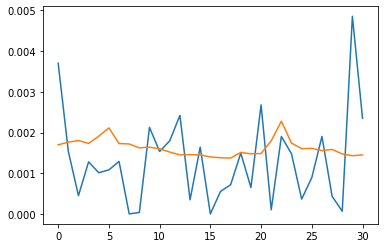

In [137]:
import matplotlib.pyplot as plt

plt.plot(np.array(final_df[['Auction_Log_Returns']][200:]))
# plt.plot(y_pred_qqq)
plt.plot(y_pred_no_Anderson)
# plt.xlim([-3, 3])
# plt.xlabel('Price Difference in $')
# plt.ylabel('Freq between Sept 2020 and Aug 2021')
# plt.title('Price Difference Between 3:50pm and Auction for MSFT')
# plt.yticks(range(0, 11, 2))
plt.show()

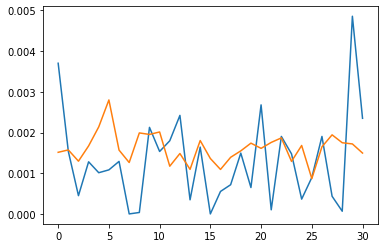

In [138]:
plt.plot(np.array(final_df[['Auction_Log_Returns']][200:]))
plt.plot(y_pred_ratio)
plt.show()

In [140]:
print(r2_score([i[0] for i in np.array(final_df[['Auction_Log_Returns']][200:])], [i for i in y_pred_ratio]))
print(r2_score(auction_log_returns[220:], auction_log_returns_340350[220:]))

# r2_score([1,2,3,4,5], [3,3,3,3,2])

-0.13968082265263293
-0.5224590553227701


In [141]:
########################################
# Linear Regression Output with Anderson + QQQ + ratio
########################################

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Model Coefficients:", model_volatility_ratio.coef_)
print("Mean Absolute Error:", mean_absolute_error(final_df[['Auction_Log_Returns']][200:], y_pred_ratio))
print("Mean Squared Error:", mean_squared_error(final_df[['Auction_Log_Returns']][200:], y_pred_ratio))
print("Coefficient of Determination:", r2_score(final_df[['Auction_Log_Returns']][200:], y_pred_ratio))

Model Coefficients: [[-2.70531084e-11 -7.42379687e-01 -9.83924470e-02  9.33760175e-04
   4.82901192e+00  9.09255239e-03  1.63786631e-01]]
Mean Absolute Error: 0.0009153332797567254
Mean Squared Error: 1.3773240207324713e-06
Coefficient of Determination: -0.13968082265263293


In [142]:
###########################################
# Linear Regression Output without Anderson
###########################################

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Printout relevant metrics
print("Model Coefficients:", model_no_volatility.coef_)
print("Mean Absolute Error:", mean_absolute_error(final_df_no_Anderson[['Auction_Log_Returns']][200:], y_pred_no_Anderson))
print("Mean Squared Error:", mean_squared_error(final_df_no_Anderson[['Auction_Log_Returns']][200:], y_pred_no_Anderson))
print("Coefficient of Determination:", r2_score(final_df_no_Anderson[['Auction_Log_Returns']][200:], y_pred_no_Anderson))

Model Coefficients: [[4.35526652e-11 1.66760465e-01]]
Mean Absolute Error: 0.0009439822201507722
Mean Squared Error: 1.3707164890425442e-06
Coefficient of Determination: -0.1342133530966494


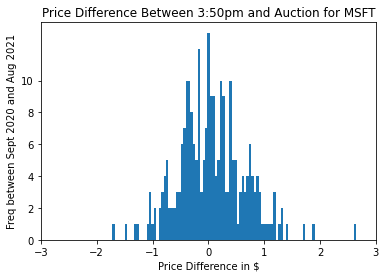

In [143]:
# Additional graphs

import matplotlib.pyplot as plt

plt.hist(merged1['Close'] - merged1['Price'], bins=100)
plt.xlim([-3, 3])
plt.xlabel('Price Difference in $')
plt.ylabel('Freq between Sept 2020 and Aug 2021')
plt.title('Price Difference Between 3:50pm and Auction for MSFT')
plt.yticks(range(0, 11, 2))
plt.show()